### Models

## - CNN 
## - CNN-LTSM 
## - VGG16 
## - ResNet50
## - Visual Transformers (ViT)
## - AlexNet
 

In [1]:
import numpy as np
import pandas as pd
import os
import pickle
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.models import Sequential, load_model
from keras.layers.core import Dense, Activation

from keras.layers import Dropout, Flatten, Input
from keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, Reshape
from keras.models import Model
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from transformers import ViTFeatureExtractor, TFViTModel

from tensorflow.keras.optimizers import Adam, SGD 
from keras.optimizers import gradient_descent_v2 

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix

from tensorflow.keras.utils import Sequence

from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
os.getcwd()

'C:\\Users\\maria\\Jupiter_Notebooks\\Dataset_Thermal_Project\\Camera_videos'

In [2]:
path_train = "../Camera_videos/Images3sec_traindata_v2"

In [5]:
path_train

'../Camera_videos/Images3sec_traindata_v2'

In [3]:
path_test = "../Camera_videos/Images_3sec_testdata_v2"

In [7]:
path_test

'../Camera_videos/Images_3sec_testdata_v2'

### Defining the class to load images   

In [4]:
class MasterImage0(object):

    def __init__(self,PATH = '', IMAGE_SIZE = 224):
        self.PATH = PATH
        self.IMAGE_SIZE = IMAGE_SIZE

        self.image_data = []
        self.x_data = []
        self.y_data = []
        self.CATEGORIES = []

        # This will get List of categories
        self.list_categories = []

    def get_categories(self):
        for path in os.listdir(self.PATH):
            if '.DS_Store' in path:
                pass
            else:
                self.list_categories.append(path)
        print("Found Categories ", self.list_categories,'\n')    
        return self.list_categories

    def process_image(self):
    
        """
        Return Numpy array of image
        :return: X_Data, Y_Data
        """
        self.CATEGORIES = self.get_categories()
        for categories in self.CATEGORIES:                                                  # Iterate over categories

            train_folder_path = os.path.join(self.PATH, categories)                         # Folder Path
            class_index = self.CATEGORIES.index(categories)                                 # this will get index for classification

            for img in os.listdir(train_folder_path):                                       # This will iterate in the Folder
                new_path = os.path.join(train_folder_path, img)                           # image Path
                
                try:        # if any image is corrupted
                    image_data_temp = cv2.imread(new_path)                 # Read Image as numbers
                    image_temp_resize = cv2.resize(image_data_temp,(self.IMAGE_SIZE,self.IMAGE_SIZE))
                    self.image_data.append([image_temp_resize,class_index])
                    random.shuffle(self.image_data)
                
                except:
                    pass

        data = np.asanyarray(self.image_data, dtype=object)
    
        # Iterate over the Data
        for x in data:
            self.x_data.append(x[0])        # Get the X_Data
            self.y_data.append(x[1])        # get the label
        print(self.x_data)
        x_data = np.asarray(self.x_data) / (255.0)      # Rescale Data
        y_data = np.asarray(self.y_data)
        
        # Reshape X_data
        x_data = x_data.reshape(-1, self.IMAGE_SIZE, self.IMAGE_SIZE, 3)     
        print("Compiled X_data", len(self.x_data))
        return x_data, y_data


    def pickle_image(self):

        """
        :return: None Creates a Pickle Object of DataSet
        """
        # Call the Function and Get the Data
        x_data,y_data = self.process_image()

        # Write the Entire Data into a Pickle File
        pickle_out = open('C:\\Users\\maria\\Jupiter_Notebooks\\Dataset_Thermal_Project\\Camera_videos\\Images3sec_traindata_v2\\x_data','wb')
        pickle.dump(x_data, pickle_out)
        pickle_out.close()

        # Write the Y Label Data
        pickle_out = open('C:\\Users\\maria\\Jupiter_Notebooks\\Dataset_Thermal_Project\\Camera_videos\\Images3sec_traindata_v2\\y_data', 'wb')
        pickle.dump(y_data, pickle_out)
        pickle_out.close()

        print("Pickled Image Successfully ")
        return x_data, y_data
        print(self.x_data)

    def load_dataset(self):

        try:
            # Read the Data from Pickle Object
            X_Temp = open('C:\\Users\\maria\\Jupiter_Notebooks\\Dataset_Thermal_Project\\Camera_videos\\Images3sec_traindata_v2\\x_data','rb')
            X_Data = pickle.load(X_Temp)

            Y_Temp = open('C:\\Users\\maria\\Jupiter_Notebooks\\Dataset_Thermal_Project\\Camera_videos\\Images3sec_traindata_v2\\y_data','rb')
            Y_Data = pickle.load(Y_Temp)

            print('Reading Dataset from Pickle Object')

            return X_Data,Y_Data

        except:
            print('Could not Found Pickle File ')
            print('Loading File and Dataset  ..........')

            x_data,y_data = self.pickle_image()
            print("X_data", self.x_data)
            return x_data,y_data
        

### Train data

In [5]:
# Using the 224 x 224 size
a = MasterImage0(PATH = path_train,IMAGE_SIZE = 224)
a

In [6]:
(all_images, all_labels) = a.load_dataset()

Reading Dataset from Pickle Object


In [7]:
print(all_images.shape, all_labels.shape)

(1209, 224, 224, 3) (1209,)


In [9]:
# 3 categories - Noone as 0, oneman as 1 and twomen as 2
np.unique(all_labels)

array([0, 1, 2])

### Test data

In [8]:
class MasterImage1(object):

    def __init__(self,PATH = '', IMAGE_SIZE = 224):
        self.PATH = PATH
        self.IMAGE_SIZE = IMAGE_SIZE

        self.image_data = []
        self.x_data = []
        self.y_data = []
        self.CATEGORIES = []

        # This will get List of categories
        self.list_categories = []

    def get_categories(self):
        for path in os.listdir(self.PATH):
            if '.DS_Store' in path:
                pass
            else:
                self.list_categories.append(path)
        print("Found Categories ", self.list_categories,'\n')    
        return self.list_categories

    def process_image(self):
    
        """
        Return Numpy array of image
        :return: X_Data, Y_Data
        """
        self.CATEGORIES = self.get_categories()
        for categories in self.CATEGORIES:                                                  # Iterate over categories

            train_folder_path = os.path.join(self.PATH, categories)                         # Folder Path
            class_index = self.CATEGORIES.index(categories)                                 # this will get index for classification

            for img in os.listdir(train_folder_path):                                       # This will iterate in the Folder
                new_path = os.path.join(train_folder_path, img)                           # image Path
                
                try:        # if any image is corrupted
                    image_data_temp = cv2.imread(new_path)                 # Read Image as numbers
                    image_temp_resize = cv2.resize(image_data_temp,(self.IMAGE_SIZE,self.IMAGE_SIZE))
                    self.image_data.append([image_temp_resize,class_index])
                    random.shuffle(self.image_data)
                
                except:
                    pass

        data = np.asanyarray(self.image_data, dtype=object)
    
        # Iterate over the Data
        for x in data:
            self.x_data.append(x[0])        # Get the X_Data
            self.y_data.append(x[1])        # get the label
        print(self.x_data)
        x_data = np.asarray(self.x_data) / (255.0)      # Rescale Data
        y_data = np.asarray(self.y_data)
        
        # Reshape X_data
        x_data = x_data.reshape(-1, self.IMAGE_SIZE, self.IMAGE_SIZE, 3)     
        print("Compiled X_data", len(self.x_data))
        return x_data, y_data


    def pickle_image(self):

        """
        :return: None Creates a Pickle Object of DataSet
        """
        # Call the Function and Get the Data
        x_data,y_data = self.process_image()

        # Write the Entire Data into a Pickle File
        pickle_out = open('C:\\Users\\maria\\Jupiter_Notebooks\\Dataset_Thermal_Project\\Camera_videos\\Images_3sec_testdata_v2\\x_data1','wb')
        pickle.dump(x_data, pickle_out)
        pickle_out.close()

        # Write the Y Label Data
        pickle_out = open('C:\\Users\\maria\\Jupiter_Notebooks\\Dataset_Thermal_Project\\Camera_videos\\Images_3sec_testdata_v2\\y_data1', 'wb')
        pickle.dump(y_data, pickle_out)
        pickle_out.close()

        print("Pickled Image Successfully ")
        return x_data, y_data
        print(self.x_data)

    def load_dataset(self):

        try:
            # Read the Data from Pickle Object
            X_Temp = open("C:\\Users\\maria\\Jupiter_Notebooks\\Dataset_Thermal_Project\\Camera_videos\\Images_3sec_testdata_v2\\x_data1",'rb')
            X_Data = pickle.load(X_Temp)

            Y_Temp = open("C:\\Users\\maria\\Jupiter_Notebooks\\Dataset_Thermal_Project\\Camera_videos\\Images_3sec_testdata_v2\\y_data1",'rb')
            Y_Data = pickle.load(Y_Temp)
        
            print('Reading Dataset from Pickle Object')

            return X_Data,Y_Data

        except:
            print('Could not Found Pickle File ')
            print('Loading File and Dataset  ..........')

            x_data,y_data = self.pickle_image()
            print("X_data", self.x_data)
            return x_data,y_data
        

In [9]:
b = MasterImage1(PATH = path_test, IMAGE_SIZE = 224)

In [10]:
(X_test_images, y_test_labels) = b.load_dataset()

Reading Dataset from Pickle Object


In [11]:
index = np.random.choice(X_test_images.shape[0])
image = X_test_images[index, :, :]
np.shape(image)

(224, 224, 3)

In [17]:
print(np.unique(y_test_labels))

[0 1]


In [12]:
print(X_test_images.shape, y_test_labels.shape)

(315, 224, 224, 3) (315,)


In [16]:
np.unique(y_test_labels)

array([0, 1])

### Defining the Man images category as '1' vs  Nobody as '0' for the Train set

In [12]:
### Defining Man or Two Man as 1 vs Nobody as 0.
all_labels_binary = np.where(all_labels==2, 1, all_labels) 

In [13]:
all_labels_binary = all_labels_binary.reshape(all_labels_binary.shape[0],1)

In [17]:
all_labels.shape

(1209,)

### Defining Train and Validation images

In [18]:
np.unique(all_labels_binary, return_counts=True, axis=0)

(array([[0],
        [1]]),
 array([386, 823], dtype=int64))

In [14]:
# Setting 25% of the training set as the validation set
X_train_images, X_val_images, y_train_labels, y_val_labels = train_test_split(all_images, all_labels_binary, stratify= all_labels_binary,random_state=12, test_size=0.25)

In [17]:
# test image counts
np.unique(y_test_labels, return_counts=True, axis=0)

(array([0, 1]), array([151, 164], dtype=int64))

In [15]:
print('Train: X_train_images=%s, y_train_labels=%s' % (X_train_images.shape, y_train_labels.shape))
print('Validation: X_val_images=%s, y_val_labels=%s' % (X_val_images.shape, y_val_labels.shape))
print('Test: X_test_images=%s, y_test_labels=%s' % (X_test_images.shape, y_test_labels.shape))

Train: X_train_images=(906, 224, 224, 3), y_train_labels=(906, 1)
Validation: X_val_images=(303, 224, 224, 3), y_val_labels=(303, 1)
Test: X_test_images=(315, 224, 224, 3), y_test_labels=(315,)


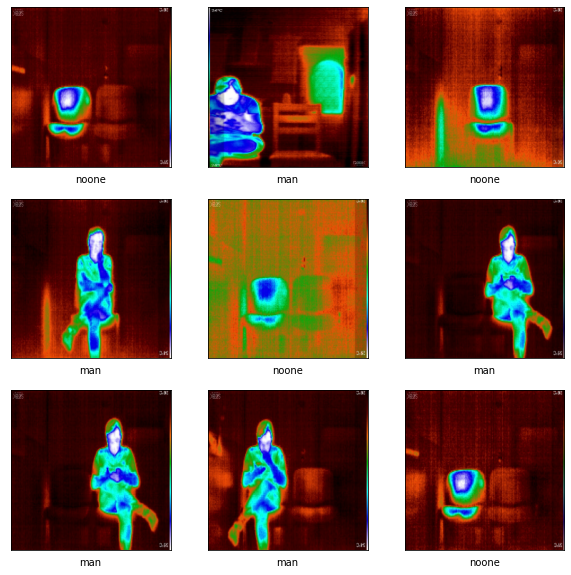

In [27]:
# Verify images from the train set
class_names = ['noone', 'man']

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train_images[i])
    plt.xlabel(class_names[y_train_labels[i][0]])
plt.show()

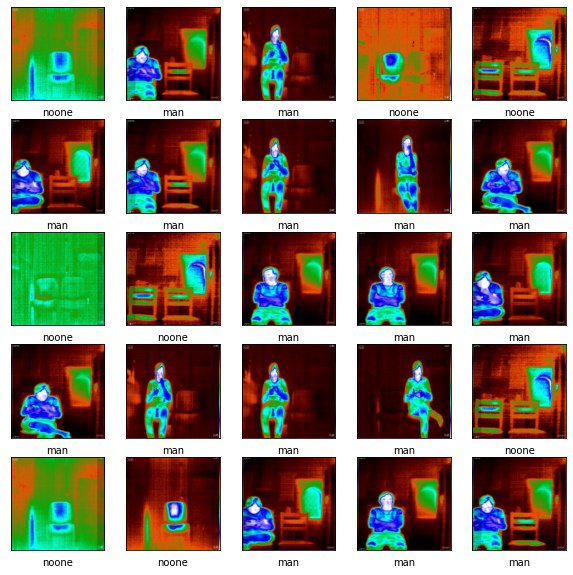

In [34]:
# Verify images from the validation set
class_names = ['noone', 'man']
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_val_images[i])
    plt.xlabel(class_names[y_val_labels[i][0]])
plt.show()

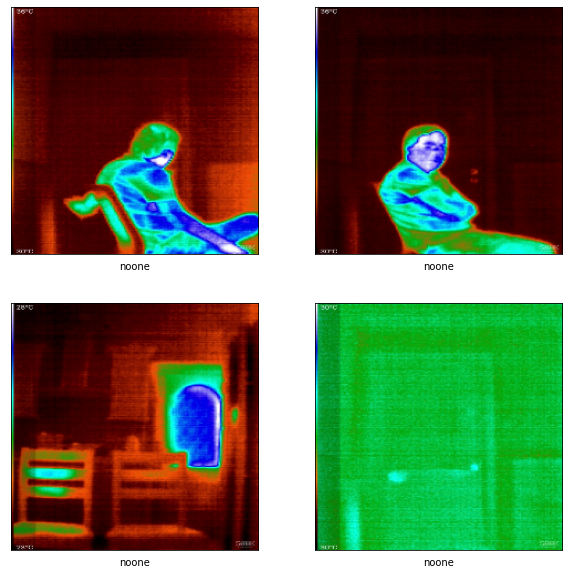

In [15]:
# Verify images from the test set

class_names = ['noone', 'man']
plt.figure(figsize=(10,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test_images[i])
    plt.xlabel(class_names[y_test_labels[i]])
plt.show()

In [94]:
y_test_labels.shape

(315,)

### Data Augmentation

See the Keras tutorial on image augmentation at https://www.tensorflow.org/tutorials/images/data_augmentation and the preprocessing layers at https://www.tensorflow.org/guide/keras/preprocessing_layers .

In [16]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"), #  Applies horizontal flipping (i.e. the man sitting on the left will swap to the right and vice versa) 
                                                # to a random 50% of the images that go through it
  layers.RandomCrop(120,120),  # Crops out a random part of an image to the size 120 x 120
  layers.RandomZoom(0.2),  # Zooms in or out of the image by a random factor in the range [-20%, +20%]
  layers.RandomRotation(0.3), # Rotates the input images by a random value in the range [–30%, +30%]
  layers.RandomContrast(factor =0.9), # Adjusts contrast during training between [10%, 90%].
])


In [39]:
#class_names = ['noone', 'man']
#plt.figure(figsize=(10,10))
#for i in range(25):
#    plt.subplot(5,5,i+1)
#    plt.xticks([])
#    plt.yticks([])    
#    augmented_images = data_augmentation(X_train_images)
#    plt.grid(False)
#    plt.imshow(augmented_images[i])
#    plt.xlabel(class_names[y_train_labels[i][0]])
#plt.show()

## CNN Model

In [25]:
input_shape = X_train_images.shape[1:]
input_shape

(224, 224, 3)

In [17]:
# Define the model  - no regularisation - basic
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

x =  keras.layers.Conv2D(32, (5,5), padding = 'same', activation = 'relu')(x)
x =  keras.layers.Conv2D(64, (3,3), padding = 'same', activation = 'relu')(x)
x =  keras.layers.MaxPooling2D(2,2)(x)
x =  keras.layers.Flatten()(x)
x =  keras.layers.Dense(64, activation = 'relu')(x)

outputs = keras.layers.Dense(1,activation='sigmoid')(x)  # for binary classification
cnn_model = Model(inputs,outputs)

cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 120, 120, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 120, 120, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 230400)            0         
                                                             

In [18]:
# Compile the model
cnn_model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics=['accuracy'])

In [29]:
# Fit the model
cnn_trained_model = cnn_model.fit( X_train_images, y_train_labels, validation_data=(X_val_images, y_val_labels),batch_size=4, verbose=2, epochs=80)

Epoch 1/80
227/227 - 7s - loss: 0.0763 - accuracy: 0.9724 - val_loss: 0.0134 - val_accuracy: 0.9967 - 7s/epoch - 31ms/step
Epoch 2/80
227/227 - 7s - loss: 0.0691 - accuracy: 0.9768 - val_loss: 0.1500 - val_accuracy: 0.9637 - 7s/epoch - 30ms/step
Epoch 3/80
227/227 - 7s - loss: 0.1059 - accuracy: 0.9636 - val_loss: 0.0300 - val_accuracy: 0.9967 - 7s/epoch - 29ms/step
Epoch 4/80
227/227 - 7s - loss: 0.0602 - accuracy: 0.9768 - val_loss: 0.0319 - val_accuracy: 0.9835 - 7s/epoch - 29ms/step
Epoch 5/80
227/227 - 7s - loss: 0.0580 - accuracy: 0.9735 - val_loss: 0.0632 - val_accuracy: 0.9736 - 7s/epoch - 30ms/step
Epoch 6/80
227/227 - 7s - loss: 0.0765 - accuracy: 0.9724 - val_loss: 0.0263 - val_accuracy: 0.9967 - 7s/epoch - 30ms/step
Epoch 7/80
227/227 - 7s - loss: 0.0615 - accuracy: 0.9735 - val_loss: 0.0264 - val_accuracy: 0.9967 - 7s/epoch - 30ms/step
Epoch 8/80
227/227 - 7s - loss: 0.0741 - accuracy: 0.9757 - val_loss: 0.8961 - val_accuracy: 0.5842 - 7s/epoch - 30ms/step
Epoch 9/80
227/2

227/227 - 11s - loss: 0.0940 - accuracy: 0.9702 - val_loss: 0.1043 - val_accuracy: 0.9967 - 11s/epoch - 49ms/step
Epoch 68/80
227/227 - 7s - loss: 0.0950 - accuracy: 0.9735 - val_loss: 0.0459 - val_accuracy: 0.9967 - 7s/epoch - 30ms/step
Epoch 69/80
227/227 - 7s - loss: 0.0628 - accuracy: 0.9757 - val_loss: 0.0307 - val_accuracy: 0.9934 - 7s/epoch - 29ms/step
Epoch 70/80
227/227 - 7s - loss: 0.0984 - accuracy: 0.9768 - val_loss: 0.2403 - val_accuracy: 0.7888 - 7s/epoch - 29ms/step
Epoch 71/80
227/227 - 7s - loss: 0.0580 - accuracy: 0.9823 - val_loss: 0.1245 - val_accuracy: 0.9604 - 7s/epoch - 29ms/step
Epoch 72/80
227/227 - 7s - loss: 0.0662 - accuracy: 0.9812 - val_loss: 0.0734 - val_accuracy: 0.9967 - 7s/epoch - 30ms/step
Epoch 73/80
227/227 - 7s - loss: 0.0596 - accuracy: 0.9779 - val_loss: 0.1055 - val_accuracy: 0.9934 - 7s/epoch - 32ms/step
Epoch 74/80
227/227 - 7s - loss: 0.0657 - accuracy: 0.9779 - val_loss: 0.0254 - val_accuracy: 0.9934 - 7s/epoch - 31ms/step
Epoch 75/80
227/22

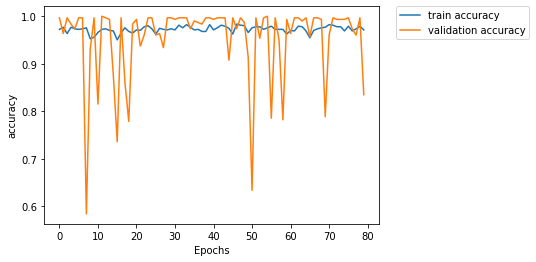

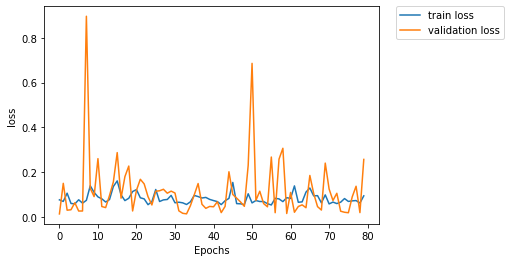

In [31]:
def plot_graphs(cnn_trained_model, string):
    plt.plot(cnn_trained_model.history[string], label="train "+string)
    plt.plot(cnn_trained_model.history['val_'+string], label="validation "+string)
    plt.xlabel("Epochs")
    plt.ylabel(string)
#    plt.legend([string, 'val_'+string])
# Place a legend to the right of this smaller subplot.
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    
    
  #Plot the accuracy and loss
plot_graphs(cnn_trained_model, "accuracy")
plot_graphs(cnn_trained_model, "loss")

In [25]:
cnn_model.save("Saved_models/cnn_model.h5")

In [35]:
scores = cnn_model.evaluate(X_test_images, y_test_labels, verbose=0)
print("CNN Accuracy on Test Set: %.2f%%" % (scores[1]*100))

CNN Accuracy on Test Set: 90.94%


In [37]:
_, train_acc = cnn_model.evaluate(X_train_images, y_train_labels, verbose=0)
_, val_acc = cnn_model.evaluate(X_val_images, y_val_labels, verbose=0)
_, test_acc = cnn_model.evaluate(X_test_images, y_test_labels, verbose=0)
print('Train accuracy: %.3f, Validation accuracy: %.3f, Test accuracy: %.3f' % (train_acc, val_acc, test_acc))

Train accuracy: 0.983, Validation accuracy: 0.997, Test accuracy: 0.909


In [38]:
y_pred_labels = cnn_model.predict(X_test_images)
y_pred_labels = y_pred_labels.flatten().round()
print(classification_report(y_test_labels, y_pred_labels, digits=3))

10/10 [==============================] - 0s 12ms/step
              precision    recall  f1-score   support

           0      0.855     0.974     0.910       151
           1      0.972     0.848     0.906       164

    accuracy                          0.908       315
   macro avg      0.913     0.911     0.908       315
weighted avg      0.916     0.908     0.908       315



In [39]:
accuracy = accuracy_score(y_test_labels, y_pred_labels)
print('CNN model Accuracy:  %.3f' % accuracy)

precision = precision_score(y_test_labels, y_pred_labels)
print('CNN model Precision: %.3f' % precision)

recall = recall_score(y_test_labels, y_pred_labels)
print('CNN model Recall: %.3f' % recall)

f1 = f1_score(y_test_labels, y_pred_labels)
print('CNN model F1-score: %.3f' % f1)

CNN model Accuracy:  0.908
CNN model Precision: 0.972
CNN model Recall: 0.848
CNN model F1-score: 0.906


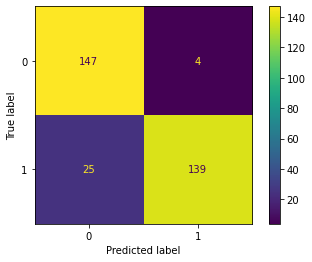

In [40]:
cmatrix = confusion_matrix(y_test_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cmatrix)
disp.plot()
plt.show() 

In [65]:
# Define the CNN model  - with regularisation

x = data_augmentation(inputs)  # Apply random data augmentation

x =  keras.layers.Conv2D(32, (5,5), padding = 'same', activation = 'relu')(x)
x =  keras.layers.Conv2D(64, (3,3), padding = 'same', activation = 'relu')(x)
x =  keras.layers.MaxPooling2D(2,2)(x)

x =  keras.layers.Conv2D(128, (3,3), padding = 'same', activation = 'relu')(x)
x =  keras.layers.MaxPooling2D(2,2)(x)
       
x =  keras.layers.Flatten()(x)
x =  keras.layers.Dense(64, activation = 'relu')(x)
x =  keras.layers.Dropout(0.2)(x)
x =  keras.layers.Dense(128, activation = 'relu')(x)
x =  keras.layers.Dropout(0.2)(x)

outputs = keras.layers.Dense(1,activation='sigmoid')(x)  # for binary classification
cnn_model_reg = Model(inputs,outputs)

cnn_model_reg.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 120, 120, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 120, 120, 32)      2432      
                                                                 
 conv2d_6 (Conv2D)           (None, 120, 120, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 60, 60, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 60, 60, 128)       73856     
                                                           

In [67]:
# Compile the model
cnn_model_reg.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics=['accuracy'])

In [68]:
# Fit the model
cnn_reg_trained_model = cnn_model_reg.fit( X_train_images, y_train_labels, validation_data=(X_val_images, y_val_labels),verbose=2, epochs=80)

Epoch 1/80
29/29 - 10s - loss: 0.5470 - accuracy: 0.7285 - val_loss: 0.3583 - val_accuracy: 0.9835 - 10s/epoch - 334ms/step
Epoch 2/80
29/29 - 7s - loss: 0.3866 - accuracy: 0.8245 - val_loss: 0.3737 - val_accuracy: 0.8548 - 7s/epoch - 248ms/step
Epoch 3/80
29/29 - 7s - loss: 0.3253 - accuracy: 0.8499 - val_loss: 0.1200 - val_accuracy: 0.9703 - 7s/epoch - 255ms/step
Epoch 4/80
29/29 - 7s - loss: 0.2890 - accuracy: 0.8742 - val_loss: 0.1869 - val_accuracy: 0.8614 - 7s/epoch - 255ms/step
Epoch 5/80
29/29 - 7s - loss: 0.2563 - accuracy: 0.8841 - val_loss: 0.1684 - val_accuracy: 0.8680 - 7s/epoch - 258ms/step
Epoch 6/80
29/29 - 7s - loss: 0.2600 - accuracy: 0.8885 - val_loss: 0.1500 - val_accuracy: 0.8944 - 7s/epoch - 249ms/step
Epoch 7/80
29/29 - 7s - loss: 0.2462 - accuracy: 0.8962 - val_loss: 0.2630 - val_accuracy: 0.9736 - 7s/epoch - 251ms/step
Epoch 8/80
29/29 - 7s - loss: 0.2245 - accuracy: 0.9051 - val_loss: 0.1312 - val_accuracy: 0.9472 - 7s/epoch - 254ms/step
Epoch 9/80
29/29 - 7s 

Epoch 60/80
29/29 - 7s - loss: 0.1183 - accuracy: 0.9614 - val_loss: 0.0784 - val_accuracy: 0.9934 - 7s/epoch - 249ms/step
Epoch 61/80
29/29 - 7s - loss: 0.1049 - accuracy: 0.9636 - val_loss: 0.0448 - val_accuracy: 0.9901 - 7s/epoch - 253ms/step
Epoch 62/80
29/29 - 7s - loss: 0.1175 - accuracy: 0.9525 - val_loss: 0.1141 - val_accuracy: 0.9769 - 7s/epoch - 248ms/step
Epoch 63/80
29/29 - 7s - loss: 0.1241 - accuracy: 0.9492 - val_loss: 0.0492 - val_accuracy: 0.9868 - 7s/epoch - 245ms/step
Epoch 64/80
29/29 - 7s - loss: 0.0914 - accuracy: 0.9702 - val_loss: 0.0516 - val_accuracy: 0.9901 - 7s/epoch - 251ms/step
Epoch 65/80
29/29 - 7s - loss: 0.1059 - accuracy: 0.9680 - val_loss: 0.0342 - val_accuracy: 0.9967 - 7s/epoch - 245ms/step
Epoch 66/80
29/29 - 7s - loss: 0.1051 - accuracy: 0.9614 - val_loss: 0.0257 - val_accuracy: 0.9967 - 7s/epoch - 249ms/step
Epoch 67/80
29/29 - 7s - loss: 0.0732 - accuracy: 0.9713 - val_loss: 0.0441 - val_accuracy: 0.9835 - 7s/epoch - 249ms/step
Epoch 68/80
29/2

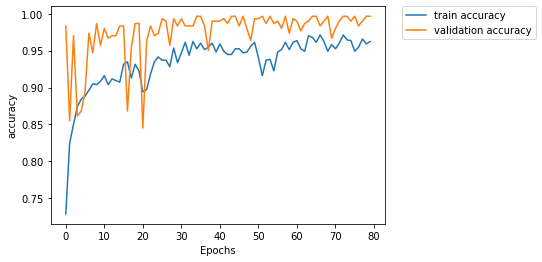

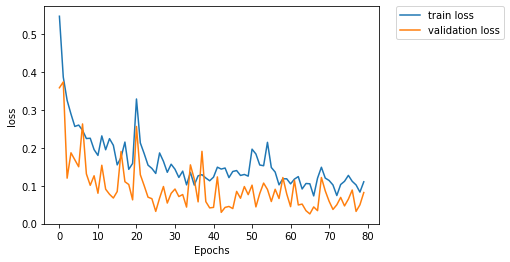

In [71]:
def plot_graphs(cnn_reg_trained_model, string):
    plt.plot(cnn_reg_trained_model.history[string], label="train "+string)
    plt.plot(cnn_reg_trained_model.history['val_'+string], label="validation "+string)
    plt.xlabel("Epochs")
    plt.ylabel(string)
#    plt.legend([string, 'val_'+string])
# Place a legend to the right of this smaller subplot.
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    
    
  #Plot the accuracy and loss
plot_graphs(cnn_reg_trained_model, "accuracy")
plot_graphs(cnn_reg_trained_model, "loss")

In [72]:
cnn_model_reg.save("Saved_models/cnn_model_with_reg.h5")

In [70]:
scores = cnn_model_reg.evaluate(X_test_images, y_test_labels, verbose=0)
print("CNN Accuracy on Test Set: %.2f%%" % (scores[1]*100))

CNN Accuracy on Test Set: 96.88%


In [73]:
_, train_acc = cnn_model_reg.evaluate(X_train_images, y_train_labels, verbose=0)
_, val_acc = cnn_model_reg.evaluate(X_val_images, y_val_labels, verbose=0)
_, test_acc = cnn_model_reg.evaluate(X_test_images, y_test_labels, verbose=0)
print('Train accuracy: %.3f, Validation accuracy: %.3f, Test accuracy: %.3f' % (train_acc, val_acc, test_acc))

Train accuracy: 0.993, Validation accuracy: 0.997, Test accuracy: 0.969


### Get accuracy, precision, recall and f measure and  confusion matrix 

In [37]:
y_pred_labels = cnn_model_reg.predict(X_test_images)
y_pred_labels = y_pred_labels.flatten().round()
print(classification_report(y_test_labels, y_pred_labels, digits=3))

10/10 [==============================] - 0s 15ms/step
              precision    recall  f1-score   support

           0      0.852     0.954     0.900       151
           1      0.952     0.848     0.897       164

    accuracy                          0.898       315
   macro avg      0.902     0.901     0.898       315
weighted avg      0.904     0.898     0.898       315



In [38]:
accuracy = accuracy_score(y_test_labels, y_pred_labels)
print('CNN reg model Accuracy:  %.3f' % accuracy)

precision = precision_score(y_test_labels, y_pred_labels)
print('CNN reg model Precision: %.3f' % precision)

recall = recall_score(y_test_labels, y_pred_labels)
print('CNN reg model Recall: %.3f' % recall)

f1 = f1_score(y_test_labels, y_pred_labels)
print('CNN reg model F1-score: %.3f' % f1)

CNN reg model Accuracy:  0.898
CNN reg model Precision: 0.952
CNN reg model Recall: 0.848
CNN reg model F1-score: 0.897


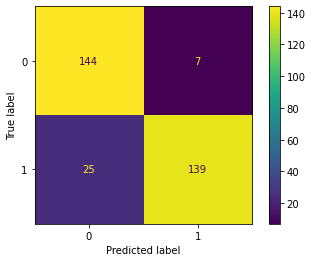

In [39]:
cmatrix = confusion_matrix(y_test_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cmatrix)
disp.plot()
plt.show()

## CNN- LTSM model

In [40]:
x = data_augmentation(inputs)  # Apply random data augmentation

x =  keras.layers.Conv2D(32, (5,5), padding = 'same', activation = 'relu')(x)
x =  keras.layers.Conv2D(64, (3,3), padding = 'same', activation = 'relu')(x)
x =  keras.layers.MaxPooling2D(2,2)(x)

x =  keras.layers.Conv2D(128, (3,3), padding = 'same', activation = 'relu')(x)
x =  keras.layers.MaxPooling2D(2,2)(x)
x =  keras.layers.Reshape((32,-1))(x)
x =  keras.layers.LSTM(64, activation = 'relu', return_sequences=False)(x)

x =  keras.layers.Dropout(0.2)(x)

outputs = keras.layers.Dense(1,activation='sigmoid')(x)  # for binary classification
cnn_ltsm_model = Model(inputs,outputs)

cnn_ltsm_model.summary()    

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 120, 120, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 120, 120, 32)      2432      
                                                                 
 conv2d_6 (Conv2D)           (None, 120, 120, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 60, 60, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 60, 60, 128)       73856     
                                                           

In [41]:
# Compile the model
cnn_ltsm_model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics=['accuracy'])

In [42]:
cnn_ltsm_trained_model = cnn_ltsm_model.fit( X_train_images, y_train_labels, validation_data=(X_val_images, y_val_labels),verbose=2, epochs=80)

Epoch 1/100
29/29 - 13s - loss: 0.6022 - accuracy: 0.6689 - val_loss: 0.4526 - val_accuracy: 0.8185 - 13s/epoch - 461ms/step
Epoch 2/100
29/29 - 11s - loss: 0.5186 - accuracy: 0.7837 - val_loss: 0.5407 - val_accuracy: 0.8647 - 11s/epoch - 370ms/step
Epoch 3/100
29/29 - 11s - loss: 0.5355 - accuracy: 0.6976 - val_loss: 0.4429 - val_accuracy: 0.7459 - 11s/epoch - 370ms/step
Epoch 4/100
29/29 - 11s - loss: 0.3820 - accuracy: 0.8267 - val_loss: 0.1722 - val_accuracy: 0.8746 - 11s/epoch - 365ms/step
Epoch 5/100
29/29 - 11s - loss: 0.3527 - accuracy: 0.8510 - val_loss: 0.2999 - val_accuracy: 0.8515 - 11s/epoch - 364ms/step
Epoch 6/100
29/29 - 11s - loss: 0.3621 - accuracy: 0.8201 - val_loss: 0.1378 - val_accuracy: 0.9439 - 11s/epoch - 366ms/step
Epoch 7/100
29/29 - 11s - loss: 0.2979 - accuracy: 0.8764 - val_loss: 0.1938 - val_accuracy: 0.8713 - 11s/epoch - 370ms/step
Epoch 8/100
29/29 - 11s - loss: 0.2726 - accuracy: 0.8808 - val_loss: 0.1700 - val_accuracy: 0.9109 - 11s/epoch - 368ms/step


29/29 - 11s - loss: 0.2069 - accuracy: 0.9128 - val_loss: 0.1265 - val_accuracy: 0.9505 - 11s/epoch - 375ms/step
Epoch 59/100
29/29 - 11s - loss: 0.2262 - accuracy: 0.9172 - val_loss: 0.1186 - val_accuracy: 0.9967 - 11s/epoch - 375ms/step
Epoch 60/100
29/29 - 11s - loss: 0.1938 - accuracy: 0.9216 - val_loss: 0.1016 - val_accuracy: 0.9703 - 11s/epoch - 371ms/step
Epoch 61/100
29/29 - 11s - loss: 0.1745 - accuracy: 0.9349 - val_loss: 0.0803 - val_accuracy: 0.9868 - 11s/epoch - 375ms/step
Epoch 62/100
29/29 - 11s - loss: 0.1870 - accuracy: 0.9161 - val_loss: 0.0996 - val_accuracy: 0.9802 - 11s/epoch - 374ms/step
Epoch 63/100
29/29 - 11s - loss: 0.1629 - accuracy: 0.9338 - val_loss: 0.0825 - val_accuracy: 0.9835 - 11s/epoch - 374ms/step
Epoch 64/100
29/29 - 11s - loss: 0.2029 - accuracy: 0.9260 - val_loss: 0.1028 - val_accuracy: 0.9802 - 11s/epoch - 373ms/step
Epoch 65/100
29/29 - 11s - loss: 0.2046 - accuracy: 0.9084 - val_loss: 0.1448 - val_accuracy: 0.8746 - 11s/epoch - 372ms/step
Epoch

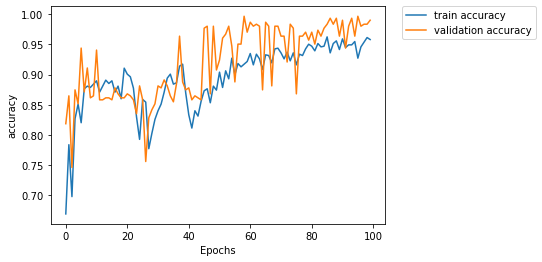

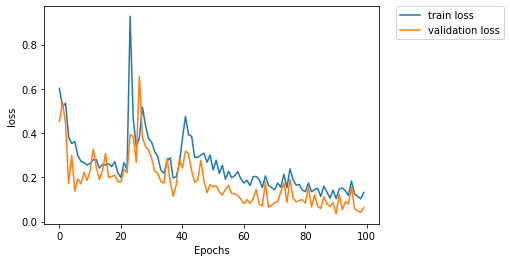

In [44]:
def plot_graphs(cnn_ltsm_trained_model, string):
 
    plt.plot(cnn_ltsm_trained_model.history[string], label="train "+string)
    plt.plot(cnn_ltsm_trained_model.history['val_'+string], label="validation "+string)
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()    
    
  #Plot the accuracy and loss
plot_graphs(cnn_ltsm_trained_model, "accuracy")
plot_graphs(cnn_ltsm_trained_model, "loss")

In [46]:
cnn_ltsm_model.save("Saved_models/cnn_ltsm_model.h5")

In [45]:
scores = cnn_ltsm_model.evaluate(X_test_images, y_test_labels, verbose=0)
print("CNN_LTSM Accuracy on Test Set: %.2f%%" % (scores[1]*100))

CNN_LTSM Accuracy on Test Set: 74.69%


In [47]:
_, train_acc = cnn_ltsm_model.evaluate(X_train_images, y_train_labels, verbose=0)
_, val_acc = cnn_ltsm_model.evaluate(X_val_images, y_val_labels, verbose=0)
_, test_acc = cnn_ltsm_model.evaluate(X_test_images, y_test_labels, verbose=0)
print('Train accuracy: %.3f, Validation accuracy: %.3f, Test accuracy: %.3f' % (train_acc, val_acc, test_acc))

Train accuracy: 0.969, Validation accuracy: 0.990, Test accuracy: 0.747


### Get accuracy, precision, recall and f measure and  confusion matrix 

In [48]:
y_pred_labels = cnn_ltsm_model.predict(X_test_images)
y_pred_labels = y_pred_labels.flatten().round()
print(classification_report(y_test_labels, y_pred_labels, digits = 3))

10/10 [==============================] - 0s 27ms/step
              precision    recall  f1-score   support

           0      0.961     0.483     0.643       151
           1      0.674     0.982     0.799       164

    accuracy                          0.743       315
   macro avg      0.817     0.733     0.721       315
weighted avg      0.811     0.743     0.724       315



In [49]:
accuracy = accuracy_score(y_test_labels, y_pred_labels)
print('CNN-LTSM model Accuracy:  %.3f' % accuracy)

precision = precision_score(y_test_labels, y_pred_labels)
print('CNN-LTSM model Precision: %.3f' % precision)

recall = recall_score(y_test_labels, y_pred_labels)
print('CNN-LTSM model Recall: %.3f' % recall)

f1 = f1_score(y_test_labels, y_pred_labels)
print('CNN-LTSM model F1-score: %.3f' % f1)

CNN-LTSM model Accuracy:  0.743
CNN-LTSM model Precision: 0.674
CNN-LTSM model Recall: 0.982
CNN-LTSM model F1-score: 0.799


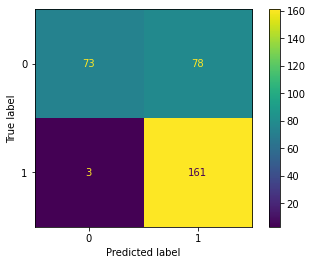

In [50]:
cmatrix = confusion_matrix(y_test_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cmatrix)
disp.plot()
plt.show()

## VGG16 model

VGG/ResNet/Inception etc are implemented following the guide on the implementation of transfer learnign from keras,  https://keras.io/guides/transfer_learning/ .

In [45]:
base_vgg = VGG16(include_top=False,weights='imagenet',input_shape=(120,120,3))  # Instantiate a base model with pre-trained weights.

base_vgg.trainable = False  # Freeze the base model

# Define VGG16 model. Adding data augmentation and new classifier layers
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

x = base_vgg(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)  # or, x = keras.layers.Global1Pooling2D()(x)
x = keras.layers.Dense(250,activation='relu')(x)
outputs = keras.layers.Dense(1,activation='sigmoid')(x)
model_VGG16 = Model(inputs,outputs)


model_VGG16.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 120, 120, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_3 (Dense)             (None, 250)               128250    
                                                                 
 dense_4 (Dense)             (None, 1)                 251       
                                                           

In [46]:
# Compile the model
model_VGG16.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

In [49]:
#Train VGG16 model
VGG16_trained_model = model_VGG16.fit( X_train_images, y_train_labels, validation_data=(X_val_images, y_val_labels), epochs=80)

Epoch 1/80
29/29 [==============================] - 8s 279ms/step - loss: 0.0715 - accuracy: 0.9702 - val_loss: 0.0152 - val_accuracy: 0.9967
Epoch 2/80
29/29 [==============================] - 8s 264ms/step - loss: 0.0895 - accuracy: 0.9658 - val_loss: 0.0112 - val_accuracy: 0.9967
Epoch 3/80
29/29 [==============================] - 8s 261ms/step - loss: 0.0739 - accuracy: 0.9768 - val_loss: 0.0077 - val_accuracy: 0.9967
Epoch 4/80
29/29 [==============================] - 8s 274ms/step - loss: 0.0737 - accuracy: 0.9614 - val_loss: 0.0083 - val_accuracy: 0.9967
Epoch 5/80
29/29 [==============================] - 8s 272ms/step - loss: 0.0713 - accuracy: 0.9757 - val_loss: 0.0100 - val_accuracy: 0.9967
Epoch 6/80
29/29 [==============================] - 8s 268ms/step - loss: 0.0782 - accuracy: 0.9702 - val_loss: 0.0092 - val_accuracy: 0.9967
Epoch 7/80
29/29 [==============================] - 9s 295ms/step - loss: 0.0823 - accuracy: 0.9757 - val_loss: 0.0102 - val_accuracy: 0.9967
Epoch 

29/29 [==============================] - 8s 272ms/step - loss: 0.0750 - accuracy: 0.9724 - val_loss: 0.0126 - val_accuracy: 0.9967
Epoch 59/80
29/29 [==============================] - 8s 270ms/step - loss: 0.0506 - accuracy: 0.9834 - val_loss: 0.0084 - val_accuracy: 0.9967
Epoch 60/80
29/29 [==============================] - 8s 269ms/step - loss: 0.0718 - accuracy: 0.9658 - val_loss: 0.0169 - val_accuracy: 0.9967
Epoch 61/80
29/29 [==============================] - 8s 268ms/step - loss: 0.0817 - accuracy: 0.9713 - val_loss: 0.0191 - val_accuracy: 0.9967
Epoch 62/80
29/29 [==============================] - 8s 269ms/step - loss: 0.0676 - accuracy: 0.9713 - val_loss: 0.0141 - val_accuracy: 0.9967
Epoch 63/80
29/29 [==============================] - 8s 267ms/step - loss: 0.0535 - accuracy: 0.9812 - val_loss: 0.0210 - val_accuracy: 0.9967
Epoch 64/80
29/29 [==============================] - 8s 270ms/step - loss: 0.0754 - accuracy: 0.9735 - val_loss: 0.0118 - val_accuracy: 0.9967
Epoch 65/80

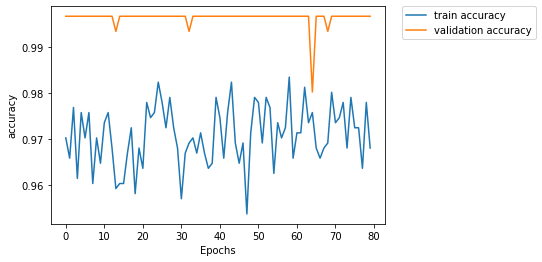

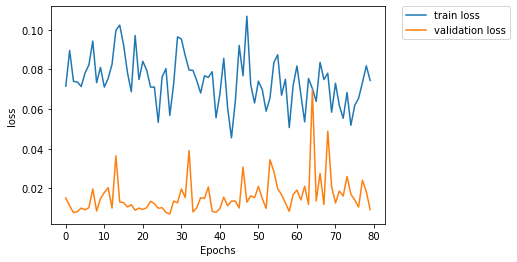

In [52]:
def plot_graphs(VGG16_trained_model, string):
    plt.plot(VGG16_trained_model.history[string], label="train "+string)
    plt.plot(VGG16_trained_model.history['val_'+string], label="validation "+string)
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    
    
  #Plot the accuracy and loss
plot_graphs(VGG16_trained_model, "accuracy")
plot_graphs(VGG16_trained_model, "loss")

In [54]:
model_VGG16.save("Saved_models/model_vgg16.h5")

In [50]:
scores = model_VGG16.evaluate(X_test_images, y_test_labels, verbose=0)
print("VGG16 Accuracy on Test Set: %.2f%%" % (scores[1]*100))

VGG16 Accuracy on Test Set: 100.00%


In [23]:
scores = model_VGG16.evaluate(X_test_images, y_test_labels, verbose=0)
print("VGG16 Accuracy on Test Set: %.2f%%" % (scores[1]*100))

VGG16 Accuracy on Test Set: 96.25%


In [53]:
_, train_acc = model_VGG16.evaluate(X_train_images, y_train_labels, verbose=0)
_, val_acc = model_VGG16.evaluate(X_val_images, y_val_labels, verbose=0)
_, test_acc = model_VGG16.evaluate(X_test_images, y_test_labels, verbose=0)
print('Train accuracy: %.3f, Validation accuracy: %.3f, Test accuracy: %.3f' % (train_acc, val_acc, test_acc))

Train accuracy: 0.989, Validation accuracy: 0.997, Test accuracy: 1.000


### Get accuracy, precision, recall and f measure and  confusion matrix 

In [55]:
y_pred_labels = model_VGG16.predict(X_test_images)
y_pred_labels = y_pred_labels.flatten().round()
print(classification_report(y_test_labels, y_pred_labels, digits = 3))

10/10 [==============================] - 1s 64ms/step
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       151
           1      1.000     1.000     1.000       164

    accuracy                          1.000       315
   macro avg      1.000     1.000     1.000       315
weighted avg      1.000     1.000     1.000       315



In [56]:
accuracy = accuracy_score(y_test_labels, y_pred_labels)
print('VGG16 model Accuracy:  %.3f' % accuracy)

precision = precision_score(y_test_labels, y_pred_labels)
print('VGG16 model Precision: %.3f' % precision)

recall = recall_score(y_test_labels, y_pred_labels)
print('VGG16 model Recall: %.3f' % recall)

f1 = f1_score(y_test_labels, y_pred_labels)
print('VGG16 model F1-score: %.3f' % f1)

VGG16 model Accuracy:  1.000
VGG16 model Precision: 1.000
VGG16 model Recall: 1.000
VGG16 model F1-score: 1.000


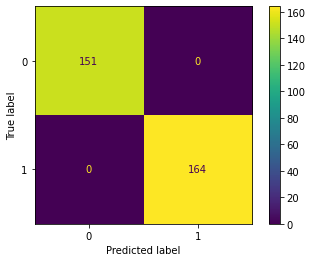

In [57]:
cmatrix = confusion_matrix(y_test_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cmatrix)
disp.plot()
plt.show()

## ResNet50 model

In [41]:
base_resnet = ResNet50(include_top=False,weights='imagenet',input_shape=(120, 120, 3)) # Instantiate a base model

base_resnet.trainable = False  # Freeze the base model

# Define ResNet50 model. Adding new classifier layers
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)

x = base_resnet(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(250,activation='relu')(x)
outputs = keras.layers.Dense(1,activation='sigmoid')(x)
model_resnet = Model(inputs,outputs)


model_resnet.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 120, 120, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_5 (Dense)             (None, 250)               512250    
                                                                 
 dense_6 (Dense)             (None, 1)                 251       
                                                           

In [42]:
# Compile the model
model_resnet.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

In [45]:
#Train ResNet model
trained_model_resnet = model_resnet.fit( X_train_images, y_train_labels, validation_data=(X_val_images, y_val_labels), epochs=80)

Epoch 1/80
29/29 [==============================] - 8s 270ms/step - loss: 0.4239 - accuracy: 0.8035 - val_loss: 0.2369 - val_accuracy: 0.8647
Epoch 2/80
29/29 [==============================] - 7s 258ms/step - loss: 0.4094 - accuracy: 0.8068 - val_loss: 0.3116 - val_accuracy: 0.8482
Epoch 3/80
29/29 [==============================] - 7s 257ms/step - loss: 0.4043 - accuracy: 0.8146 - val_loss: 0.2894 - val_accuracy: 0.8548
Epoch 4/80
29/29 [==============================] - 7s 259ms/step - loss: 0.3857 - accuracy: 0.8300 - val_loss: 0.4568 - val_accuracy: 0.8251
Epoch 5/80
29/29 [==============================] - 8s 260ms/step - loss: 0.3824 - accuracy: 0.8333 - val_loss: 0.3298 - val_accuracy: 0.8482
Epoch 6/80
29/29 [==============================] - 8s 261ms/step - loss: 0.3892 - accuracy: 0.8377 - val_loss: 0.4264 - val_accuracy: 0.8284
Epoch 7/80
29/29 [==============================] - 8s 263ms/step - loss: 0.4144 - accuracy: 0.8102 - val_loss: 0.2838 - val_accuracy: 0.8548
Epoch 

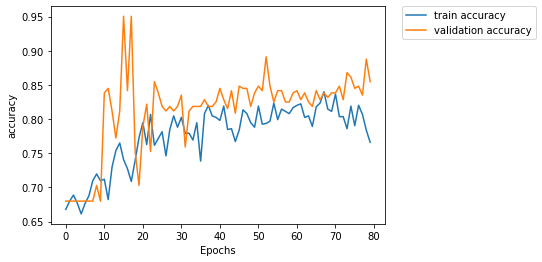

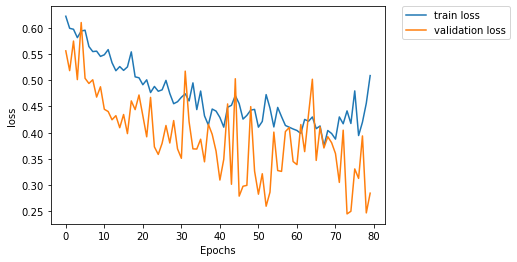

In [38]:
def plot_graphs(trained_model_resnet, string):
    plt.plot(trained_model_resnet.history[string], label="train "+string)
    plt.plot(trained_model_resnet.history['val_'+string], label="validation "+string)
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    
    
  #Plot the accuracy and loss
plot_graphs(trained_model_resnet, "accuracy")
plot_graphs(trained_model_resnet, "loss")

In [40]:
model_resnet.save("Saved_models/model_resnet.h5")

In [39]:
scores = model_resnet.evaluate(X_test_images, y_test_labels, verbose=0)
print("ResNet50 Accuracy on Test Set: %.2f%%" % (scores[1]*100))

ResNet50 Accuracy on Test Set: 68.44%


In [41]:
_, train_acc = model_resnet.evaluate(X_train_images, y_train_labels, verbose=0)
_, val_acc = model_resnet.evaluate(X_val_images, y_val_labels, verbose=0)
_, test_acc = model_resnet.evaluate(X_test_images, y_test_labels, verbose=0)
print('Train accuracy: %.3f, Validation accuracy: %.3f, Test accuracy: %.3f' % (train_acc, val_acc, test_acc))

Train accuracy: 0.847, Validation accuracy: 0.855, Test accuracy: 0.684


### Get accuracy, precision, recall and f measure and  confusion matrix 

In [42]:
y_pred_labels = model_resnet.predict(X_test_images)
y_pred_labels = y_pred_labels.flatten().round()
print(classification_report(y_test_labels, y_pred_labels, digits = 3))

10/10 [==============================] - 1s 35ms/step
              precision    recall  f1-score   support

           0      1.000     0.331     0.498       151
           1      0.619     1.000     0.765       164

    accuracy                          0.679       315
   macro avg      0.809     0.666     0.631       315
weighted avg      0.802     0.679     0.637       315



In [43]:
accuracy = accuracy_score(y_test_labels, y_pred_labels)
print('ResNet50 model Accuracy:  %.3f' % accuracy)

precision = precision_score(y_test_labels, y_pred_labels)
print('ResNet50 model Precision: %.3f' % precision)

recall = recall_score(y_test_labels, y_pred_labels)
print('ResNet50 model Recall: %.3f' % recall)

f1 = f1_score(y_test_labels, y_pred_labels)
print('ResNet50 model F1-score: %.3f' % f1)

ResNet50 model Accuracy:  0.679
ResNet50 model Precision: 0.619
ResNet50 model Recall: 1.000
ResNet50 model F1-score: 0.765


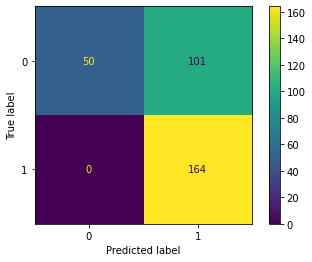

In [44]:
cmatrix = confusion_matrix(y_test_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cmatrix)
disp.plot()
plt.show()

## Vision Transfomer (ViT) model

In [32]:
# Base model pre-trained on ImageNet-21k with the 224x224 image resolution
base_model = TFViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch16-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [33]:
# Google's model is pre-trained on 224x224 image resolution so cant resize by RandomCrop.
data_augmentation_vit = tf.keras.Sequential([
  layers.RandomFlip("horizontal"), 
#  layers.RandomCrop(120,120),   
  layers.RandomZoom(0.2),  
  layers.RandomRotation(0.3),
  layers.RandomContrast(factor =0.9),
])

In [34]:
# Freeze base model
base_model.trainable = False
# Create new model
inputs = keras.Input(shape = (3, 224, 224))
x = data_augmentation_vit(inputs)

vit = base_model.vit(inputs)[0]
vit = keras.layers.GlobalAveragePooling1D()(vit)
vit = tf.keras.layers.Dense(256, activation='relu')(vit)
vit = tf. keras.layers.Dropout(0.15)(vit)
outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='outputs')(vit)

model_vit = tf.keras.Model(inputs, outputs)
print(model_vit.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3, 224, 224)]     0         
                                                                 
 vit (TFViTMainLayer)        TFBaseModelOutputWithPoo  86389248  
                             ling(last_hidden_state=(            
                             None, 197, 768),                    
                              pooler_output=(None, 76            
                             8),                                 
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 global_average_pooling1d (G  (None, 768)              0         
 lobalAveragePooling1D)                                          
                                                           

In [35]:
# Compile the model
model_vit.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

In [57]:
X_train_images.shape

(906, 224, 224, 3)

In [58]:
X_val_images.shape

(303, 224, 224, 3)

In [59]:
X_test_images.shape

(315, 224, 224, 3)

In [36]:
# Reshaping for the model training
X_train_images_ = np.reshape(X_train_images, (906, 3, 224, 224))
X_val_images_ = np.reshape(X_val_images, (303, 3, 224, 224))
X_test_images_ = np.reshape(X_test_images, (315, 3, 224, 224))

In [40]:
#Train ViT model
trained_model_vit = model_vit.fit( X_train_images_, y_train_labels, validation_data=(X_val_images_, y_val_labels), epochs=80)

Epoch 1/80
29/29 [==============================] - 9s 321ms/step - loss: 4.0568e-05 - accuracy: 1.0000 - val_loss: 2.8194e-05 - val_accuracy: 1.0000
Epoch 2/80
29/29 [==============================] - 9s 314ms/step - loss: 4.1021e-05 - accuracy: 1.0000 - val_loss: 2.8752e-05 - val_accuracy: 1.0000
Epoch 3/80
29/29 [==============================] - 9s 315ms/step - loss: 3.2797e-05 - accuracy: 1.0000 - val_loss: 2.6228e-05 - val_accuracy: 1.0000
Epoch 4/80
29/29 [==============================] - 17s 594ms/step - loss: 3.0337e-05 - accuracy: 1.0000 - val_loss: 2.5593e-05 - val_accuracy: 1.0000
Epoch 5/80
29/29 [==============================] - 22s 782ms/step - loss: 3.3115e-05 - accuracy: 1.0000 - val_loss: 2.4946e-05 - val_accuracy: 1.0000
Epoch 6/80
29/29 [==============================] - 9s 316ms/step - loss: 3.8360e-05 - accuracy: 1.0000 - val_loss: 2.4475e-05 - val_accuracy: 1.0000
Epoch 7/80
29/29 [==============================] - 12s 415ms/step - loss: 2.9714e-05 - accuracy: 

29/29 [==============================] - 9s 324ms/step - loss: 8.6417e-06 - accuracy: 1.0000 - val_loss: 7.9997e-06 - val_accuracy: 1.0000
Epoch 56/80
29/29 [==============================] - 9s 325ms/step - loss: 9.2667e-06 - accuracy: 1.0000 - val_loss: 7.7714e-06 - val_accuracy: 1.0000
Epoch 57/80
29/29 [==============================] - 9s 324ms/step - loss: 9.2933e-06 - accuracy: 1.0000 - val_loss: 7.6810e-06 - val_accuracy: 1.0000
Epoch 58/80
29/29 [==============================] - 9s 325ms/step - loss: 8.6786e-06 - accuracy: 1.0000 - val_loss: 7.6055e-06 - val_accuracy: 1.0000
Epoch 59/80
29/29 [==============================] - 9s 324ms/step - loss: 1.1256e-05 - accuracy: 1.0000 - val_loss: 7.4338e-06 - val_accuracy: 1.0000
Epoch 60/80
29/29 [==============================] - 9s 325ms/step - loss: 9.2106e-06 - accuracy: 1.0000 - val_loss: 7.3174e-06 - val_accuracy: 1.0000
Epoch 61/80
29/29 [==============================] - 9s 327ms/step - loss: 1.5388e-05 - accuracy: 1.0000 -

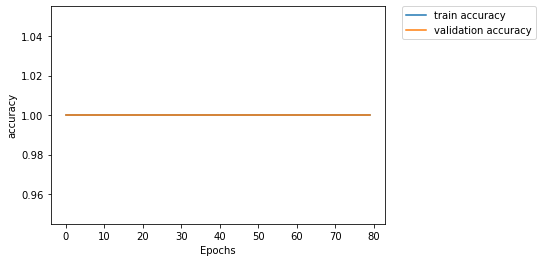

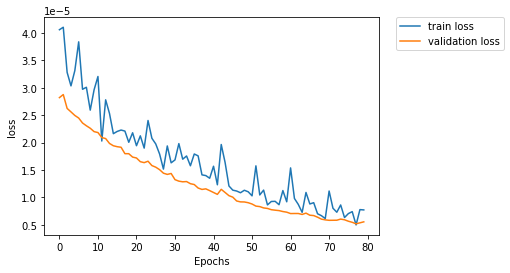

In [43]:
def plot_graphs(trained_model_vit, string):
    plt.plot(trained_model_vit.history[string], label="train "+string)
    plt.plot(trained_model_vit.history['val_'+string], label="validation "+string)
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    
    
  #Plot the accuracy and loss
plot_graphs(trained_model_vit, "accuracy")
plot_graphs(trained_model_vit, "loss")

In [39]:
model_vit.save("Saved_models/model_vit.h5")

In [41]:
scores = model_vit.evaluate(X_test_images_, y_test_labels, verbose=0)
print("ViT Accuracy on Test Set: %.2f%%" % (scores[1]*100))

ViT Accuracy on Test Set: 65.91%


In [52]:
scores = model_vit.evaluate(X_test_images_, y_test_labels, verbose=0)
print("ViT Accuracy on Test Set: %.2f%%" % (scores[1]*100))

ViT Accuracy on Test Set: 64.98%


In [44]:
_, train_acc = model_vit.evaluate(X_train_images_, y_train_labels, verbose=0)
_, val_acc = model_vit.evaluate(X_val_images_, y_val_labels, verbose=0)
_, test_acc = model_vit.evaluate(X_test_images_, y_test_labels, verbose=0)
print('Train accuracy: %.3f, Validation accuracy: %.3f, Test accuracy: %.3f' % (train_acc, val_acc, test_acc))

Train accuracy: 1.000, Validation accuracy: 1.000, Test accuracy: 0.659


### Get accuracy, precision, recall and f measure and  confusion matrix 

In [54]:
y_predict_labels = model_vit.predict(X_test_images_)
y_predict_labels = y_predict_labels.flatten().round()
print(classification_report(y_test_labels, y_predict_labels, digits = 3))

10/10 [==============================] - 4s 230ms/step
              precision    recall  f1-score   support

           0      0.583     1.000     0.737       151
           1      1.000     0.341     0.509       164

    accuracy                          0.657       315
   macro avg      0.792     0.671     0.623       315
weighted avg      0.800     0.657     0.618       315



In [55]:
accuracy = accuracy_score(y_test_labels, y_predict_labels)
print('ViT model Accuracy:  %.3f' % accuracy)

precision = precision_score(y_test_labels, y_predict_labels)
print('ViT model Precision: %.3f' % precision)

recall = recall_score(y_test_labels, y_predict_labels)
print('ViT model Recall: %.3f' % recall)

f1 = f1_score(y_test_labels, y_predict_labels)
print('ViT model F1-score: %.3f' % f1)

ViT model Accuracy:  0.657
ViT model Precision: 1.000
ViT model Recall: 0.341
ViT model F1-score: 0.509


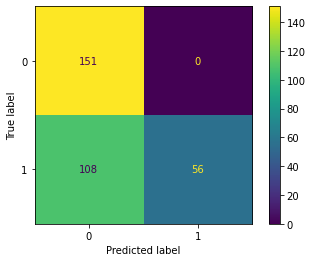

In [56]:
cmatrix = confusion_matrix(y_test_labels, y_predict_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cmatrix)
disp.plot()
plt.show()

## AlexNet  

 It was originally designed for multi-classification. may not work as expected with binary classification?

In [29]:
## AlexNet model architecture

inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)

x =  keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu')(x)
x =  keras.layers.BatchNormalization()(x)
x =  keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
x =  keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same")(x)
x =  keras.layers.BatchNormalization()(x)
x =  keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
x =  keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(x)
x =  keras.layers.BatchNormalization()(x)
x =  keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(x)
x =  keras.layers.BatchNormalization()(x)
x =  keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(x)
x =  keras.layers.BatchNormalization()(x)
x =  keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
x =  keras.layers.Flatten()(x)
x =  keras.layers.Dense(4096, activation='relu')(x)
x =  keras.layers.Dropout(0.5)(x)
x =  keras.layers.Dense(4096, activation='relu')(x)
x =  keras.layers.Dropout(0.5)(x)

outputs = keras.layers.Dense(1,activation='sigmoid')(x)
model_alexnet = Model(inputs,outputs)

print(model_alexnet.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 120, 120, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 256)       6146

In [30]:
# Compile the model
model_alexnet.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics=['accuracy'])

In [34]:
# Fit the model
trained_model_alexnet = model_alexnet.fit( X_train_images, y_train_labels, validation_data=(X_val_images, y_val_labels),verbose=2, epochs=80)

Epoch 1/80
29/29 - 8s - loss: 0.1061 - accuracy: 0.9592 - val_loss: 0.0416 - val_accuracy: 0.9901 - 8s/epoch - 260ms/step
Epoch 2/80
29/29 - 7s - loss: 0.1275 - accuracy: 0.9503 - val_loss: 0.0098 - val_accuracy: 1.0000 - 7s/epoch - 251ms/step
Epoch 3/80
29/29 - 7s - loss: 0.1324 - accuracy: 0.9570 - val_loss: 0.0112 - val_accuracy: 1.0000 - 7s/epoch - 254ms/step
Epoch 4/80
29/29 - 7s - loss: 0.1220 - accuracy: 0.9625 - val_loss: 0.0017 - val_accuracy: 1.0000 - 7s/epoch - 250ms/step
Epoch 5/80
29/29 - 8s - loss: 0.1754 - accuracy: 0.9371 - val_loss: 0.0533 - val_accuracy: 0.9802 - 8s/epoch - 261ms/step
Epoch 6/80
29/29 - 7s - loss: 0.1319 - accuracy: 0.9470 - val_loss: 0.0810 - val_accuracy: 0.9802 - 7s/epoch - 251ms/step
Epoch 7/80
29/29 - 7s - loss: 0.1208 - accuracy: 0.9592 - val_loss: 0.0943 - val_accuracy: 0.9505 - 7s/epoch - 257ms/step
Epoch 8/80
29/29 - 7s - loss: 0.1451 - accuracy: 0.9625 - val_loss: 0.0901 - val_accuracy: 0.9703 - 7s/epoch - 255ms/step
Epoch 9/80
29/29 - 7s - 

Epoch 68/80
29/29 - 7s - loss: 0.2010 - accuracy: 0.9216 - val_loss: 0.2074 - val_accuracy: 0.9340 - 7s/epoch - 251ms/step
Epoch 69/80
29/29 - 8s - loss: 0.2168 - accuracy: 0.9272 - val_loss: 0.2034 - val_accuracy: 0.9109 - 8s/epoch - 262ms/step
Epoch 70/80
29/29 - 7s - loss: 0.1441 - accuracy: 0.9492 - val_loss: 0.1048 - val_accuracy: 0.9340 - 7s/epoch - 257ms/step
Epoch 71/80
29/29 - 7s - loss: 0.1136 - accuracy: 0.9547 - val_loss: 0.0322 - val_accuracy: 1.0000 - 7s/epoch - 255ms/step
Epoch 72/80
29/29 - 7s - loss: 0.4385 - accuracy: 0.9525 - val_loss: 0.0289 - val_accuracy: 0.9868 - 7s/epoch - 256ms/step
Epoch 73/80
29/29 - 7s - loss: 0.4052 - accuracy: 0.9349 - val_loss: 0.1052 - val_accuracy: 0.9505 - 7s/epoch - 257ms/step
Epoch 74/80
29/29 - 7s - loss: 0.2817 - accuracy: 0.9404 - val_loss: 0.2100 - val_accuracy: 0.9208 - 7s/epoch - 257ms/step
Epoch 75/80
29/29 - 7s - loss: 0.4023 - accuracy: 0.9194 - val_loss: 0.0214 - val_accuracy: 0.9967 - 7s/epoch - 256ms/step
Epoch 76/80
29/2

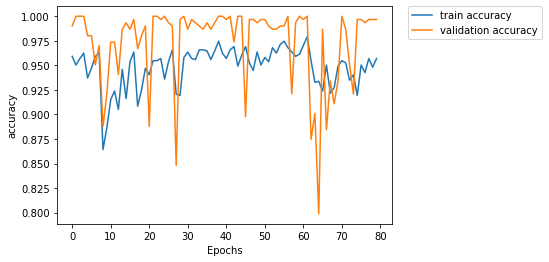

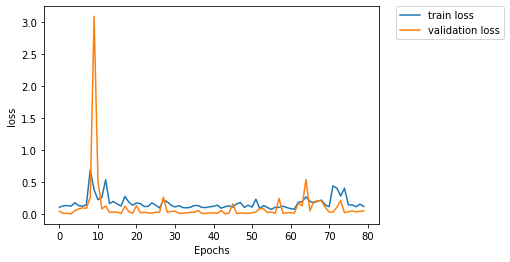

In [37]:
def plot_graphs(trained_model_alexnet, string):
    plt.plot(trained_model_alexnet.history[string], label="train "+string)
    plt.plot(trained_model_alexnet.history['val_'+string], label="validation "+string)
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    
    
  #Plot the accuracy and loss
plot_graphs(trained_model_alexnet, "accuracy")
plot_graphs(trained_model_alexnet, "loss")

In [26]:
model_alexnet.save("Saved_models/model_alexnet.h5")

In [35]:
scores = model_alexnet.evaluate(X_test_images, y_test_labels, verbose=0)
print("AlexNet Accuracy on Test Set: %.2f%%" % (scores[1]*100))

AlexNet Accuracy on Test Set: 95.31%


In [36]:
_, train_acc = model_alexnet.evaluate(X_train_images, y_train_labels, verbose=0)
_, val_acc = model_alexnet.evaluate(X_val_images, y_val_labels, verbose=0)
_, test_acc = model_alexnet.evaluate(X_test_images, y_test_labels, verbose=0)
print('Train accuracy: %.3f, Validation accuracy: %.3f, Test accuracy: %.3f' % (train_acc, val_acc, test_acc))

Train accuracy: 0.975, Validation accuracy: 0.997, Test accuracy: 0.953


### Get accuracy, precision, recall and f measure and  confusion matrix 

In [38]:
y_pred_labels = model_alexnet.predict(X_test_images)
y_pred_labels = y_pred_labels.flatten().round()
print(classification_report(y_test_labels, y_pred_labels, digits  =3))

10/10 [==============================] - 0s 35ms/step
              precision    recall  f1-score   support

           0      0.925     0.980     0.952       151
           1      0.981     0.927     0.953       164

    accuracy                          0.952       315
   macro avg      0.953     0.953     0.952       315
weighted avg      0.954     0.952     0.952       315



In [39]:
accuracy = accuracy_score(y_test_labels, y_pred_labels)
print('AlexNet model Accuracy:  %.3f' % accuracy)

precision = precision_score(y_test_labels, y_pred_labels)
print('AlexNet model Precision: %.3f' % precision)

recall = recall_score(y_test_labels, y_pred_labels)
print('AlexNet model Recall: %.3f' % recall)

f1 = f1_score(y_test_labels, y_pred_labels)
print('AlexNet model F1-score: %.3f' % f1)

AlexNet model Accuracy:  0.952
AlexNet model Precision: 0.981
AlexNet model Recall: 0.927
AlexNet model F1-score: 0.953


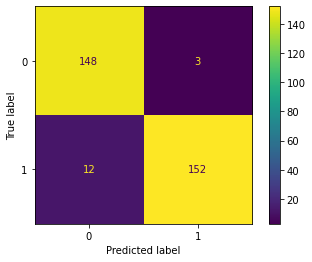

In [40]:
cmatrix = confusion_matrix(y_test_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cmatrix)
disp.plot()
plt.show()